# Importação dos modulos

In [16]:
import pandas as pd
from datetime import datetime
import os
import requests

In [17]:
address_df = pd.read_csv('./data/rideaddress_v1.csv', sep=';')
ride_df = pd.read_csv('./data/ride_v2.csv', sep=';')
estimative_df = pd.read_csv('./data/rideestimative_v3.csv', sep=';')
product_df = pd.read_csv('./data/product.csv', sep=';')

address_df = address_df[["Address", "Lat", "Lng", "RideAddressTypeID", "RideID"]]
ride_df = ride_df[["RideID", "Create", "price"]]
estimative_df = estimative_df[["RideID", "ProductID", "Price"]]

C:\Users\lucca\AppData\Local\Temp\ipykernel_3068\473383268.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  address_df = pd.read_csv('./data/rideaddress_v1.csv', sep=';')


In [18]:
address_df.rename(columns={
    "Address": "address",
    "Lat": "lat",
    "Lng": "long",
    "RideAddressTypeID": "address_type",
    "RideID": "ride_id"
}, inplace=True)

ride_df.rename(columns={
    "RideID": "ride_id",
    "Create": "date",
    "price": "price"
}, inplace=True)

estimative_df.rename(columns={
    "RideID": "ride_id",
    "ProductID": "product_id",
    "Price": "estimative_price"
}, inplace=True)

In [19]:
# Ajusta a string de data: remove espaços e limita os microssegundos a 6 dígitos
def fix_date_str(date_str):
    date_str = date_str.strip()
    if '.' in date_str:
        parts = date_str.split('.')
        if len(parts[1]) > 6:
            return parts[0] + '.' + parts[1][:6]
    return date_str

# Aplica o ajuste na coluna "date"
ride_df['fixed_date'] = ride_df['date'].apply(fix_date_str)

# Converte para datetime sem formato fixo
ride_df['datetime'] = pd.to_datetime(ride_df['fixed_date'], errors='coerce')
if ride_df['datetime'].isnull().any():
    print("Atenção: Algumas datas não foram convertidas corretamente!")

# Cria as colunas "date", "time" e "weekday" com formatação desejada
ride_df['date_only'] = ride_df['datetime'].dt.date.astype(str)  # YYYY-MM-DD
ride_df['time'] = ride_df['datetime'].dt.strftime('%H:%M:%S')      # HH:MM:SS, sem microssegundos
ride_df['weekday'] = ride_df['datetime'].dt.weekday + 1            # Segunda = 1, Domingo = 7

# Busca feriados via API para os anos presentes na coluna datetime
years = ride_df['datetime'].dt.year.unique()
holiday_dates = set()
for year in years:
    api_url = f"https://brasilapi.com.br/api/feriados/v1/{year}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            feriados = response.json()
            for feriado in feriados:
                holiday_dates.add(feriado.get('date'))
    except Exception as e:
        print(f"Erro ao acessar API para o ano {year}: {e}")

# Cria a coluna "is_holiday" verificando se a data é feriado
ride_df['is_holiday'] = ride_df['date_only'].apply(lambda d: d in holiday_dates)

# Remove as colunas intermediárias e renomeia "date_only" para "date"
ride_df.drop(columns=['date', 'datetime', 'fixed_date'], inplace=True)
ride_df.rename(columns={'date_only': 'date'}, inplace=True)

# Exibe as primeiras linhas para validar a correção
ride_df.head()

,ride_id,price,date,time,weekday,is_holiday
0,1685755,0.00,2025-02-10,14:31:10,1,False
1,1685754,30.45,2025-02-10,14:26:35,1,False
2,1685753,11.40,2025-02-10,14:24:32,1,False
3,1685752,45.79,2025-02-10,14:23:12,1,False
4,1685751,17.28,2025-02-10,14:19:30,1,False


In [20]:
import numpy as np

def haversine_distance_m(lat1, lon1, lat2, lon2):
    R = 6371e3  # Earth radius in meters
    # Convert values to float after replacing comma with dot if present and then to radians
    lat1, lon1, lat2, lon2 = [float(str(x).replace(',', '.')) for x in [lat1, lon1, lat2, lon2]]
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Round to nearest integer meter
    return int(round(R * c))

# Pivot address_df to get coordinates in columns for each ride_id based on address_type (1 and 2)
# This creates columns like 'lat_1', 'lat_2', 'long_1', 'long_2'
pivot_df = address_df.pivot(index='ride_id', columns='address_type', values=['lat', 'long'])
pivot_df.columns = [f"{col[0]}_{col[1]}" for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

# Calculate distance_line in meters for ride_ids that have both address types
pivot_df['distance_line'] = pivot_df.apply(
    lambda row: haversine_distance_m(row['lat_1'], row['long_1'], row['lat_2'], row['long_2'])
    if pd.notnull(row['lat_1']) and pd.notnull(row['lat_2']) else np.nan,
    axis=1
)

# Merge the calculated distance back into the original address_df (all rows for a given ride_id get the same distance)
address_df = address_df.merge(pivot_df[['ride_id', 'distance_line']], on='ride_id', how='left')


In [21]:
address_df.head(50)

,address,lat,long,address_type,ride_id,distance_line
0,"Rua João Pinheiro, 585 - Rua João Pinheiro - B...",-26.329754299999998,-48.840427999999996,1,1183200,21306
1,"Av. Dr. Nereu Ramos, 450 - Rocio Grande, São F...",-26.2554657,-48.6434197,2,1183200,21306
2,rid,-27.4919788,-48.528287999999996,1,1183201,14205
3,Angeloni Ingleses (Florianópolis) - Supermerca...,-27.4371486,-48.39824309999999,2,1183201,14205
4,"Rua Barão do Rio Branco, 12 - Rua Barão do Rio...",-19.8495799,-44.019915999999995,1,1183202,12799
5,"R. Antônio de Albuquerque, 1080 - Funcionários...",-19.936899,-43.9401603,2,1183202,12799
6,"Tv. Duzentos e Sessenta e Um, 72, 72",-23.9624233,-46.25465759999999,1,1183203,18671
7,"Semar Supermercados Bertioga, 2141",-23.8373074,-46.1321725,2,1183203,18671
8,"Rua Argentina, 160 - Rua Argentina - Brasil",-10.9198019,-37.077441799999995,1,1183204,1801
9,"R. Simeão Aguiar, 430 - Novo Paraíso, Aracaju ...",-10.9071288,-37.0877194,2,1183204,1801


In [22]:
#display how many lines the price is above 1000
var = 100
print(f"Quantidade de linhas com preço acima de {var}: {len(ride_df[ride_df['price'] > var])}")
#delete the lines with price above 
#ride_df = ride_df[ride_df['price'] <= var]

# display how many lines the price is under 10
var = 10
print(f"Quantidade de linhas com preço abaixo de {var}: {len(ride_df[ride_df['price'] < var])}")

# display how many lines the distance is 0
var = 0
print(f"Quantidade de linhas com distância igual a {var}: {len(address_df[address_df['distance_line'] == var])}")

# display how many lines the price is 0
var = 0
print(f"Quantidade de linhas com preço igual a {var}: {len(ride_df[ride_df['price'] == var])}")

# delete distance = 0 and price = 0 lines
address_df = address_df[address_df['distance_line'] != 0]
ride_df = ride_df[ride_df['price'] != 0]


Quantidade de linhas com preço acima de 100: 12837
Quantidade de linhas com preço abaixo de 10: 85171
Quantidade de linhas com distância igual a 0: 2902
Quantidade de linhas com preço igual a 0: 26630


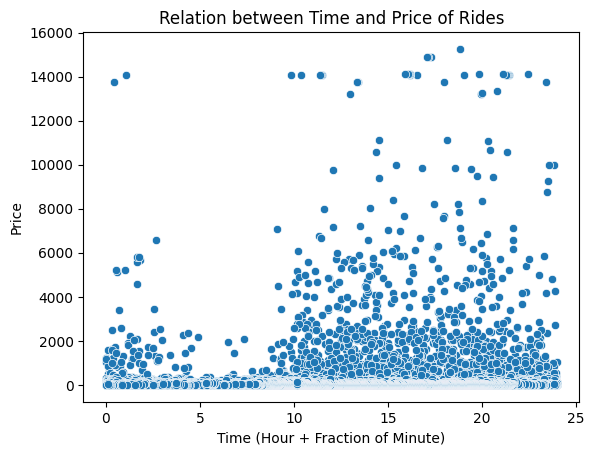

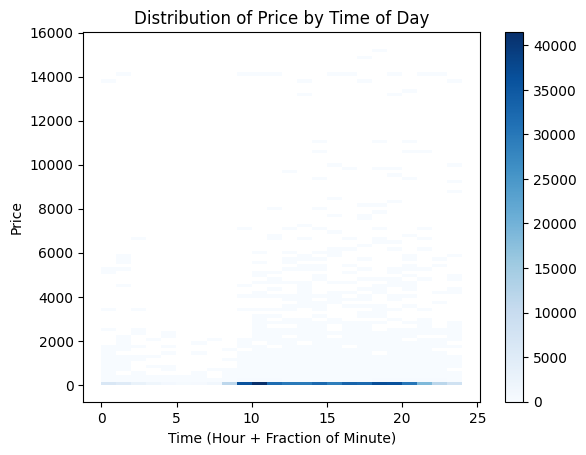

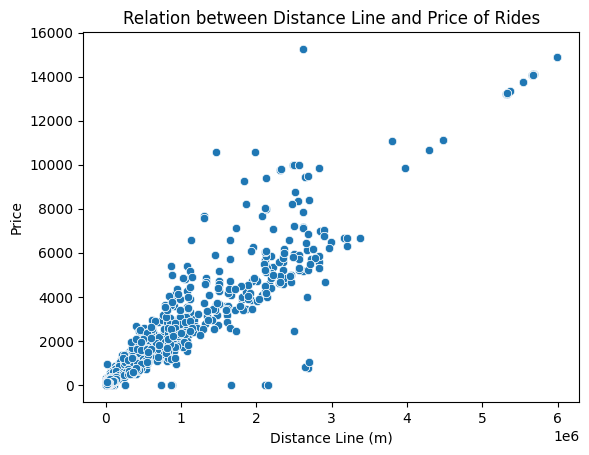

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Converte a coluna "time" (no formato HH:MM:SS) para um datetime e extrai a hora em formato numérico
ride_df['time_dt'] = pd.to_datetime(ride_df['time'], format='%H:%M:%S')
ride_df['hour_min'] = ride_df['time_dt'].dt.hour + ride_df['time_dt'].dt.minute/60

# Plota a relação entre time (hora + fração de minuto) e price
sns.scatterplot(x='hour_min', y='price', data=ride_df)
plt.xlabel('Time (Hour + Fraction of Minute)')
plt.ylabel('Price')
plt.title('Relation between Time and Price of Rides')
plt.show()

# best distribution for price x time of the day
sns.histplot(ride_df, x='hour_min', y='price', bins=(24, 100), cmap="Blues", cbar=True)
plt.xlabel('Time (Hour + Fraction of Minute)')
plt.ylabel('Price')
plt.title('Distribution of Price by Time of Day')
plt.show()

# Plota a relação entre distance_line_y na "address_df" e price na "ride_df"
sns.scatterplot(x='distance_line', y='price', data=ride_df.merge(address_df[['ride_id', 'distance_line']], on='ride_id'))
plt.xlabel('Distance Line (m)')
plt.ylabel('Price')
plt.title('Relation between Distance Line and Price of Rides')
plt.show()


In [24]:
ride_df.head()

,ride_id,price,date,time,weekday,is_holiday,time_dt,hour_min
1,1685754,30.45,2025-02-10,14:26:35,1,False,1900-01-01 14:26:35,14.433333
2,1685753,11.40,2025-02-10,14:24:32,1,False,1900-01-01 14:24:32,14.400000
3,1685752,45.79,2025-02-10,14:23:12,1,False,1900-01-01 14:23:12,14.383333
4,1685751,17.28,2025-02-10,14:19:30,1,False,1900-01-01 14:19:30,14.316667
5,1685750,43.45,2025-02-10,14:18:11,1,False,1900-01-01 14:18:11,14.300000


In [25]:
# Merge ride_df with address_df on 'ride_id'
df = pd.merge(ride_df, address_df[['ride_id', 'distance_line']], on='ride_id', how='inner')
df.head()

,ride_id,price,date,time,weekday,is_holiday,time_dt,hour_min,distance_line
0,1685754,30.45,2025-02-10,14:26:35,1,False,1900-01-01 14:26:35,14.433333,6621
1,1685754,30.45,2025-02-10,14:26:35,1,False,1900-01-01 14:26:35,14.433333,6621
2,1685753,11.40,2025-02-10,14:24:32,1,False,1900-01-01 14:24:32,14.400000,878
3,1685753,11.40,2025-02-10,14:24:32,1,False,1900-01-01 14:24:32,14.400000,878
4,1685752,45.79,2025-02-10,14:23:12,1,False,1900-01-01 14:23:12,14.383333,7469


In [26]:
# Convert columns as needed
# Convert is_holiday (if boolean) to int (0/1)
df['is_holiday'] = df['is_holiday'].astype(int)

# Convert time to a numeric feature (hour + minute fraction)
df['time_dt'] = pd.to_datetime(df['time'], format='%H:%M:%S')
df['hour_min'] = df['time_dt'].dt.hour + df['time_dt'].dt.minute/60

# Convert date string to datetime and extract day, month, and year
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Define feature columns and target
features = ['hour_min', 'weekday', 'is_holiday', 'distance_line', 'day', 'month', 'year']
target = 'price'

print(df[features + [target]].head())

    hour_min  weekday  is_holiday  distance_line  day  month  year  price
0  14.433333        1           0           6621   10      2  2025  30.45
1  14.433333        1           0           6621   10      2  2025  30.45
2  14.400000        1           0            878   10      2  2025  11.40
3  14.400000        1           0            878   10      2  2025  11.40
4  14.383333        1           0           7469   10      2  2025  45.79


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
preds = model.predict(X_test)

# Compute RMSE to evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

RMSE: 54.938776633675865


In [34]:
results = X_test.copy()
results['actual_price'] = y_test
results['predicted_price'] = preds
results.head(1000)

#acuracia do modelo
accuracy = model.score(X_test, y_test)
print("Acurácia do modelo:", accuracy)


Acurácia do modelo: 0.9021008668926394


In [33]:
# Interface para inserir os dados e obter a previsão de preço
def predict_price():
    try:
        hour_min = float(input("Digite hour_min (por exemplo, 15.5 para 15:30): "))
        weekday = int(input("Digite weekday (Segunda=1, ... Domingo=7): "))
        is_holiday = int(input("É feriado? Digite 1 para Sim ou 0 para Não: "))
        distance_line = float(input("Digite distance_line (em metros): "))
        day = int(input("Digite o dia do mês: "))
        month = int(input("Digite o mês (número): "))
        year = int(input("Digite o ano (ex: 2025): "))
    except Exception as e:
        print("Erro na entrada de dados. Tente novamente.")
        return

    # Cria um DataFrame com os dados de entrada
    features_input = pd.DataFrame({
        'hour_min': [hour_min],
        'weekday': [weekday],
        'is_holiday': [is_holiday],
        'distance_line': [distance_line],
        'day': [day],
        'month': [month],
        'year': [year]
    })
    
    # Previsão usando o modelo treinado
    predicted_price = model.predict(features_input)[0]
    print(f"\nPreço previsto: R$ {predicted_price:.2f}")

# Chama a interface
predict_price()


Preço previsto: R$ 24.06
